In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print("MAE train: ", mae_train)
    print("MAE test: ", mae_test)
    print("RMSE train: ", rmse_train)
    print("RMSE test: ", rmse_test)
    print("R2 train: ", r2_train)
    print("R2 test: ", r2_test)

In [3]:
df = pd.read_csv('../../data/pre_train/gspc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

C:\Users\santi\AppData\Local\Temp\ipykernel_14208\2841548648.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


In [4]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [7]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [11]:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i + n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

In [12]:
time_steps = 30

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

train_size = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [14]:
n_features = X_train.shape[2] 

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, n_features)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.1012 - mae: 0.2482 - val_loss: 0.0030 - val_mae: 0.0423
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0092 - mae: 0.0756 - val_loss: 0.0199 - val_mae: 0.1340
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0059 - mae: 0.0611 - val_loss: 0.0132 - val_mae: 0.1081
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0053 - mae: 0.0557 - val_loss: 0.0114 - val_mae: 0.1019
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0043 - mae: 0.0501 - val_loss: 0.0097 - val_mae: 0.0937
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0041 - mae: 0.0492 - val_loss: 0.0083 - val_mae: 0.0861
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039 - mae: 0.0488 - val_loss: 0.0105 - val_mae: 0.0978
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - mae: 0.0448 - val_loss: 0.0072 - val_mae: 0.0798
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.003

In [17]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [18]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [20]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.017137960029549714
MAE test:  0.03723245834051297
RMSE train:  0.022859707009930532
RMSE test:  0.04177813035742159
R2 train:  0.9738037225874241
R2 test:  0.5894744642553398


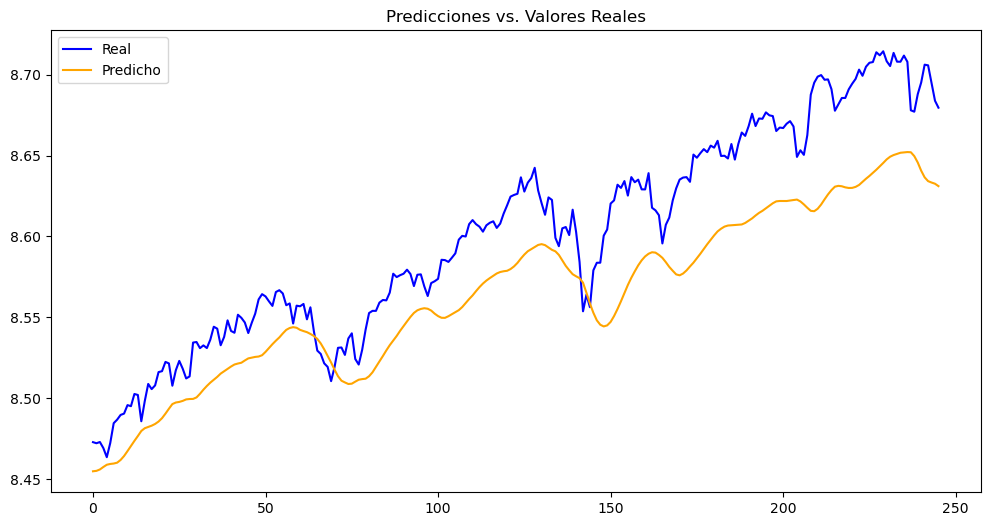

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label="Real", color="blue")
plt.plot(y_pred_test_real, label="Predicho", color="orange")
plt.title("Predicciones vs. Valores Reales")
plt.legend()
plt.show()